# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

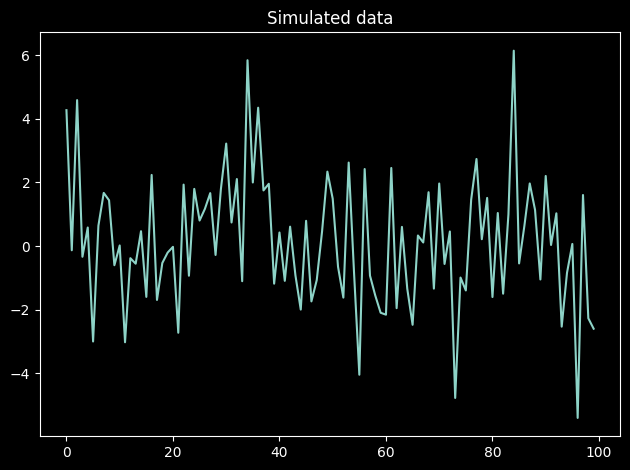

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [4]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

In [5]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.774,0.146,0.501,1.052,0.001,0.000,60785.0,98506.0,1.0
beta[1],0.813,0.140,0.552,1.079,0.001,0.000,60730.0,98365.0,1.0
beta[2],0.831,0.125,0.596,1.065,0.000,0.000,77030.0,118877.0,1.0
beta[3],0.371,0.138,0.110,0.630,0.001,0.000,56650.0,91441.0,1.0
sigsq,1.911,0.272,1.423,2.425,0.001,0.001,72971.0,108750.0,1.0


In [6]:
print(state.divergences)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


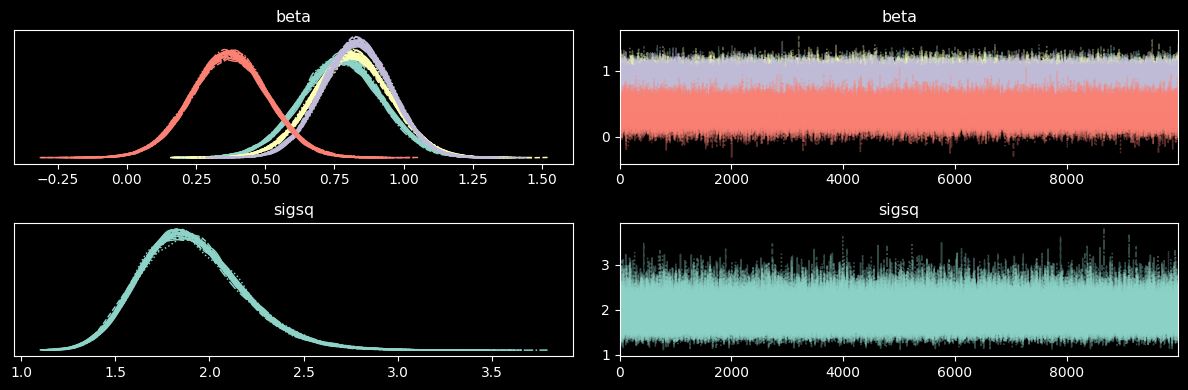

In [7]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [8]:
warmup = cv_adaptation(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    num_chains=8,
    model_warmup_iter=10_000,
    fold_warmup_iter=10_000,
    batch_size=100,
)

MEADS warmup for 2 model(s) (16 chains)...
Meads warmup done in 4.11 seconds. 
Step size: [0.4093991 0.3350817] Alpha: [0.59539795 0.53102386] Delta: [0.29769897 0.26551193]
MEADS warmup for 10 folds per model (160 chains)...
MEADS warmup took 0 min 3.4 sec


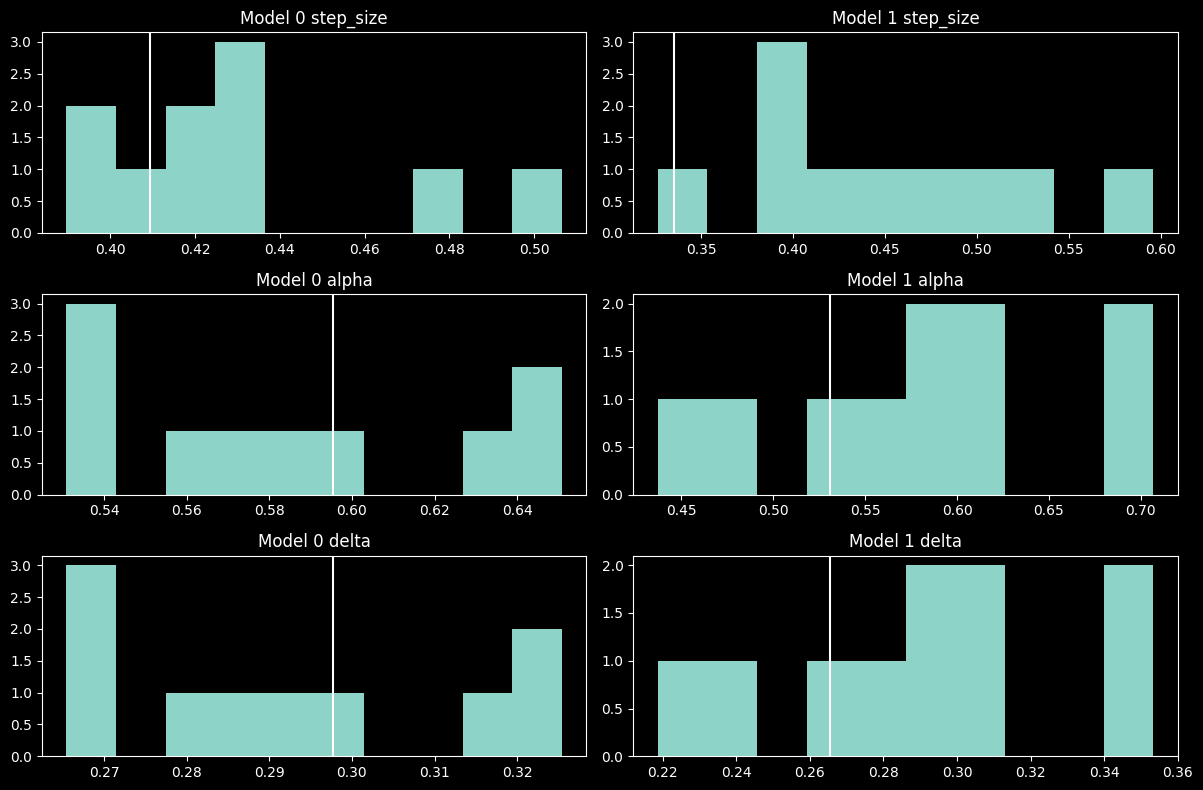

In [9]:
warmup.plot_dist()

In [10]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 160 parallel GHMC chains...
Triggered stoprule after 3 batches in 7 seconds
  10.  A: -176.92 ±1.57 B: -179.95 ±1.75 Diff: 3.03 ±0.70 stop
  20.  A: -176.92 ±1.57 B: -179.94 ±1.76 Diff: 3.02 ±0.69 stop
  30.  A: -176.91 ±1.57 B: -179.94 ±1.76 Diff: 3.03 ±0.69 stop
  40.  A: -176.90 ±1.57 B: -179.92 ±1.75 Diff: 3.02 ±0.70 stop
Drew 800000 samples in 1 min 37 sec (8269 per sec)


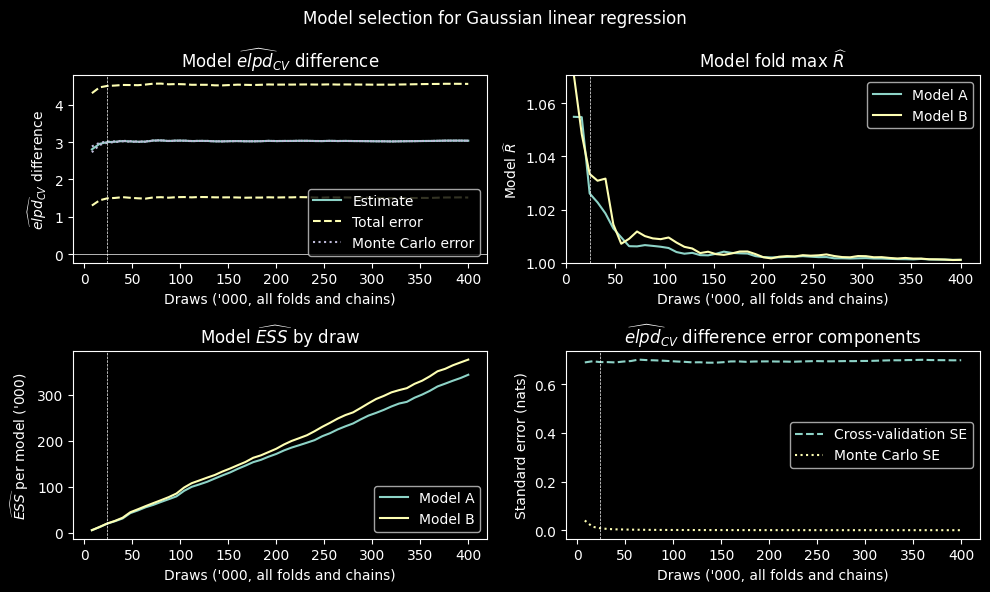

In [11]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

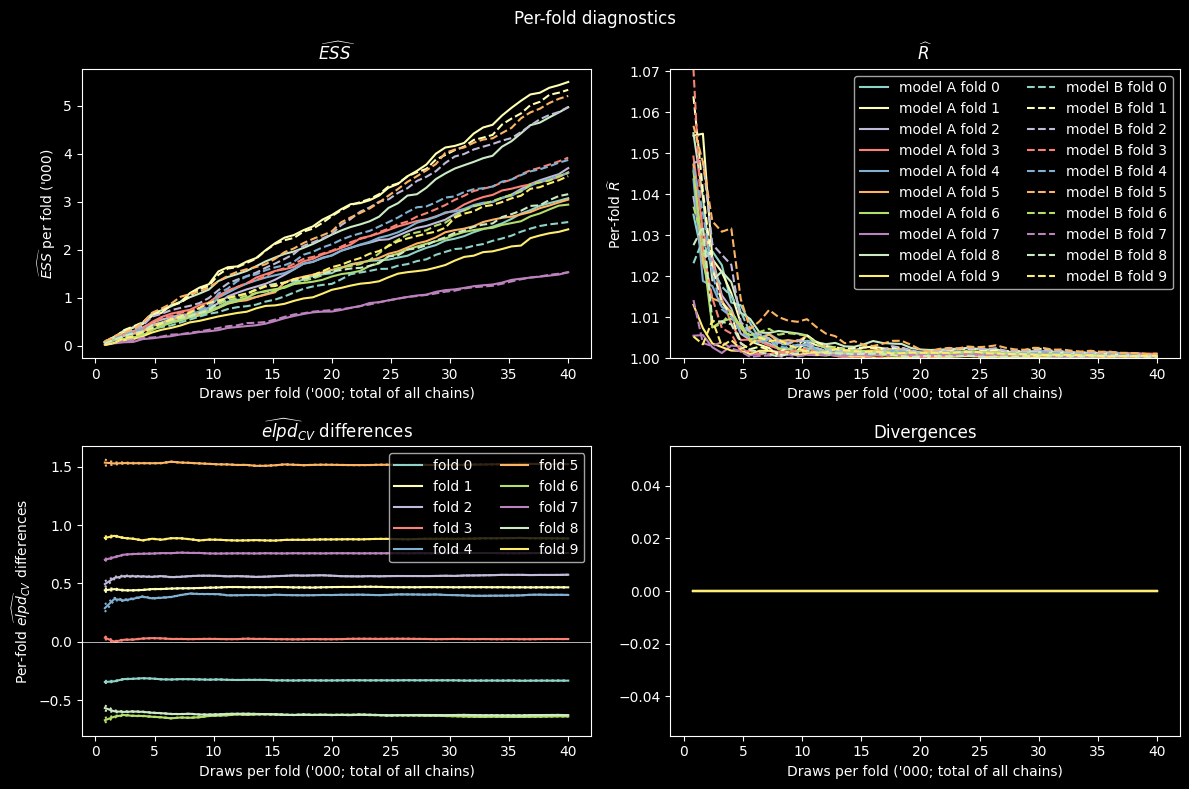

In [12]:
plot_fold_results(results, title='Per-fold diagnostics')